# Описание проекта и данных

Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. 
Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

Описание колонок:


experimentVariant – вариант эксперимента


version – версия приложения


purchase – факт покупки

# Решение

In [46]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

проводим A/A-тест на оригинальном сете данных

In [47]:
df = pd.read_csv('hw_aa.csv', sep = ';')

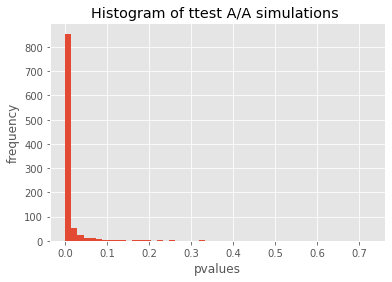

0.941

In [48]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[df.experimentVariant == 1]['purchase'].sample(n_s, replace = False).values
    s2 = df[df.experimentVariant == 0]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Вывод: ожидаемо, группы отличаются

In [49]:
df.groupby('experimentVariant', as_index = False).agg({'purchase':'mean'})
#конверсии покупок уже различаются, на 3 процента

,experimentVariant,purchase
0,0,0.023945
1,1,0.053242


In [51]:
#Посмотрим на конверсию и колличество людей в разрезе версий и экспериметов
df.groupby(['experimentVariant','version'], as_index = False).agg({'purchase':'mean', 'uid':'count' })

,experimentVariant,version,purchase,uid
0,0,v2.8.0,0.000993,41283
1,0,v2.9.0,0.074658,11921
2,0,v3.7.4.0,0.059943,4204
3,0,v3.8.0.0,0.057604,5694
4,1,v2.8.0,0.045606,41552
5,1,v2.9.0,0.071304,12033
6,1,v3.7.4.0,0.063018,4221
7,1,v3.8.0.0,0.062848,6110


Cплитование нормальное, а вот различия в конверсии по версии v2.8.0 большое - 4 процента.
Учитывая, что это у нас самая большая подгруппа, различие 4 процента в целевой метрике - сильный камень преткновения  для АА теста. Попробуем её исключить и перезапустить АА-тест.

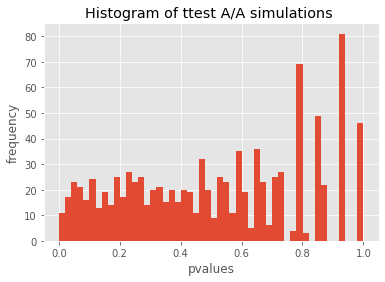

0.041

In [44]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[(df.experimentVariant == 1)& (df.version != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    s2 = df[(df.experimentVariant == 0)& (df.version != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

AA-тест сработал хорошо, распределение похоже на нормальное и pvalue < 0.05. Проблема была в версии v2.8.0. 